In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_hopf, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
def evaluateSimulation(traj):
    model = search.getModelFromTraj(traj)
    model.randomICs()
    defaultDuration = model.params['duration']
      
    model.params['duration'] = defaultDuration
    model.params.xinit = np.array([1.])
    model.run()
           
    max_amp_output = np.max(
          np.max(model.output[:, 500:], axis=1) 
        - np.min(model.output[:, 500:], axis=1)
    )
    max_output = np.max(model.output[:, 500:])

    result = {
        "end" : 3,
        "max_output": max_output, 
        "max_amp_output" : max_amp_output,
    }
    
    search.saveToPypet(result, traj)
    return 

In [4]:
model = HopfModel()

model.params['dt'] = 0.1 # Integration time step, ms
model.params['duration'] = 5 * 1000 # Simulation time, ms
model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
model.params["x_ou_mean"] = 0.
model.params["y_ou_mean"] = 0.
model.params.x_ext = [0.]
model.params.y_ext = [0.]

In [24]:
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.parameterSpace import ParameterSpace
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func
import neurolib.optimize.exploration.explorationUtils as eu

parameters = ParameterSpace({"x_ou_mean": np.linspace(-1., 1.0, 11), 
                             "y_ou_mean": np.linspace(-1., 1., 11),
                             }, kind="grid")

search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename='fhn-bifurcation-diagram.hdf')

MainProcess root INFO     Number of processes: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/fhn-bifurcation-diagram.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 121
MainProcess root INFO     BoxSearch: Environment initialized.


In [25]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-02-15-19H-17M-53S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-02-15-19H-17M-53S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2023-02-15-19H-17M-53S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-02-15-19H-17M-53S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [26]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/fhn-bifurcation-diagram.hdf
MainProcess root INFO     Analyzing trajectory results-2023-02-15-19H-17M-53S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/fhn-bifurcation-diagram.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2023-02-15-19H-17M-53S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 121/121 [00:00<00:00, 173.33it/s]
MainProcess root INFO     All results loaded.


In [2]:
comp_points = [[-0.5, 0.], [0.5, 0.], [0., 0.]]

[-0.5, 0.0]
[0.0, -0.5]
[0.5, 0.0]
[0.0, 0.5]
[0.0, 0.0]


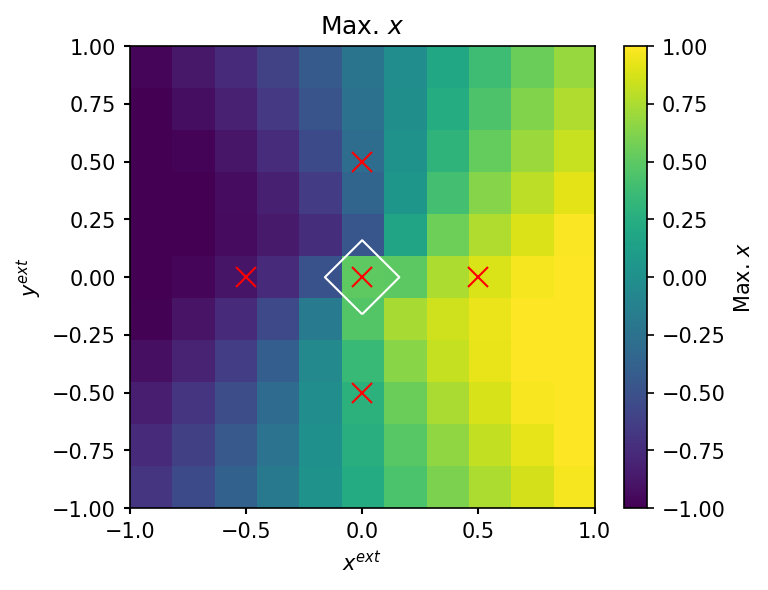

In [58]:
plot_key_label = "Max. $x$"
eu.plotExplorationResults(search.dfResults, 
                          par1=['x_ou_mean', '$x^{ext}$'], 
                          par2=['y_ou_mean', '$y^{ext}$'], 
                          plot_key='max_output',
                          plot_clim=[-1., 1.],
                          nan_to_zero=False,
                          plot_key_label=plot_key_label, 
                          one_figure=False,
                          contour=["max_amp_output"],
                          contour_color=[['white']],
                          contour_levels=[[0.2]],
                          contour_alpha=[1.0],
                          contour_kwargs={0 : {"linewidths" : (1,)}},
                          mask_threshold=0.1,
                          mask_alpha=0.2,
                          points=comp_points,
                          )

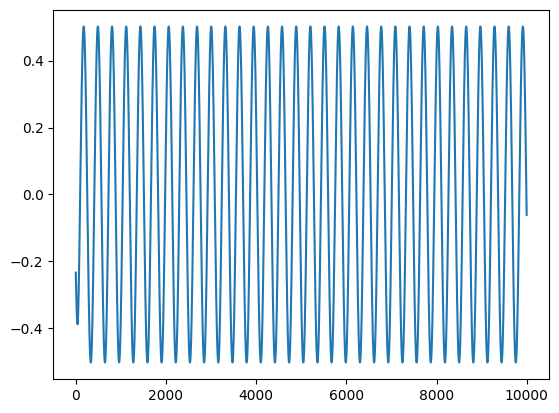

target oscillation period =  31.4


In [3]:
model = HopfModel()

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params["x_ext"] = [0.]
model.params["y_ext"] = [0.]

model.params.x_ou_mean = comp_points[2][0]
model.params.y_ou_mean = comp_points[2][1]

model.run()

plt.plot(model.x[0,:])
plt.show()

peaks = scipy.signal.find_peaks(model.x[0,100:])[0]
plist = []
for pind in range(1, len(peaks)):
    plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

period = np.around(np.mean(plist),1)
print("target oscillation period = ", period)

In [4]:
duration = 300.
model.params.duration = duration
zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
controlmat = np.zeros((1,2))
controlmat[0,0] = 1.

-825


In [42]:
results = dict()
w2_array = [1e-2, 1e-3, 1e-4, 1e-5]

results["task"] = ["FF_up", "FF_down", "FF_osc", "P_up", "P_down", "P_osc", "AC_up", "AC_down", "AC_osc"]
results["periods"] = [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ],
                       [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]

results["controls"] =  [ [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ],
                       [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ], [ None, None, None, None ] ]

241


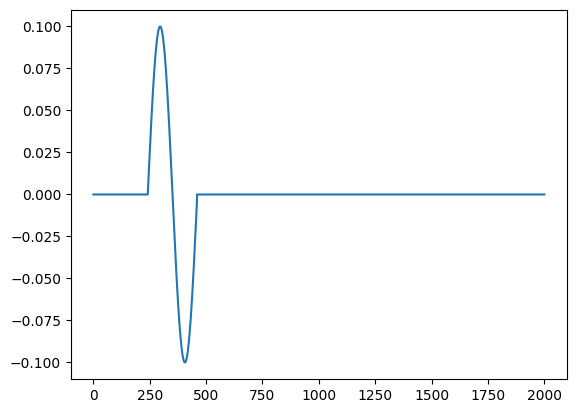

In [57]:
amp = 1e-1
target_period = 0.7*period
int0 = int(2000 - (8. * target_period / model.params.dt))
print(int0)

def getinit(shape):
    inp_ = np.zeros((shape))
    for t in range(int0, int0+int(1*target_period / model.params.dt)):
        inp_[0,0,t] = amp * np.sin(2.*np.pi*dt*(t-int0)/target_period)

    return inp_

plt.plot(getinit( (1,2,2001) )[0,0,:])
plt.show()

def getperiods(xs, pr):
    peaks = scipy.signal.find_peaks(xs, prominence=pr)[0]
    periods = []
    for i in range(1, len(peaks)):
        periods.append((peaks[i] - peaks[i-1])*dt)

    print(periods)

    return periods

# Fourier, phase, and auto-correlation cost at four different points, with different weights

--------------------------------
--------------------------------
--------------------------------
POINT :  [-0.5, 0.0]
Target period =  21.979999999999997
--------------------------------
--------------------------------
--------------------------------
POINT :  [0.5, 0.0]
Target period =  21.979999999999997
--------------------------------
--------------------------------
--------------------------------
POINT :  [0.0, 0.0]
Target period =  21.979999999999997
--------------------------------
FOURIER COST
Optimal control with target oscillation period
L2 cost weight =  0.01
Compute control for a deterministic system
Cost in iteration 0: -1.6123113857543734
Final cost : -1.6123113858242168
[16.7, 22.1, 22.1, 22.1, 22.1, 22.200000000000003, 21.1, 12.0, 22.0, 22.1, 22.0, 22.1, 22.200000000000003]


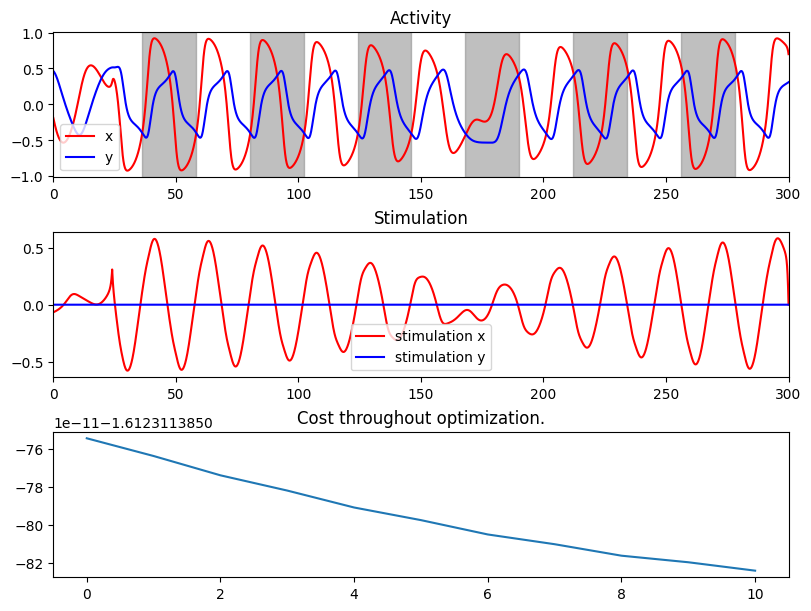

Optimal control with target oscillation period
L2 cost weight =  0.001
Compute control for a deterministic system
Cost in iteration 0: -2.0360796128394654
Final cost : -2.036080288257532
[18.2, 21.900000000000002, 21.6, 21.200000000000003, 21.5, 21.5, 17.1, 19.700000000000003, 21.700000000000003, 21.900000000000002, 21.900000000000002, 22.0, 22.1]


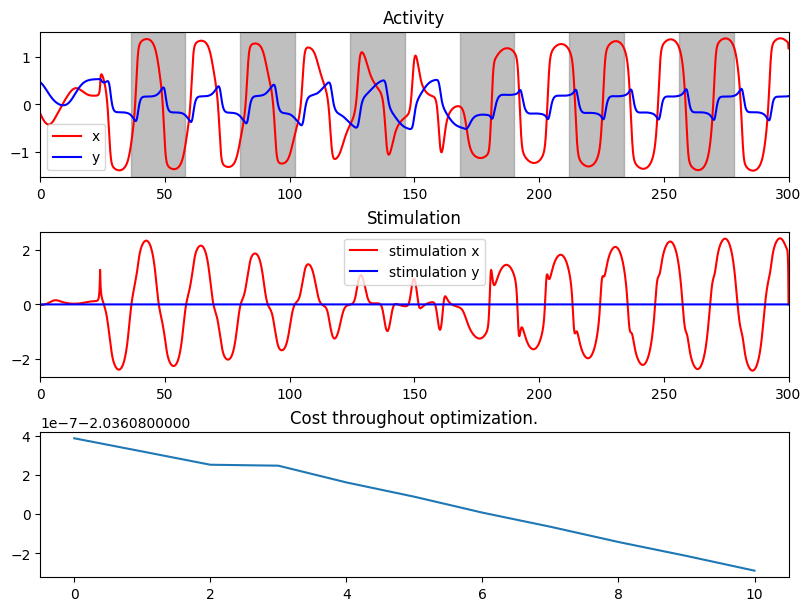

Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -2.5360193283017067
Final cost : -2.5360193335555836
[12.9, 22.0, 22.1, 22.1, 22.3, 23.8, 18.8, 19.6, 15.3, 21.700000000000003, 22.0, 22.1]


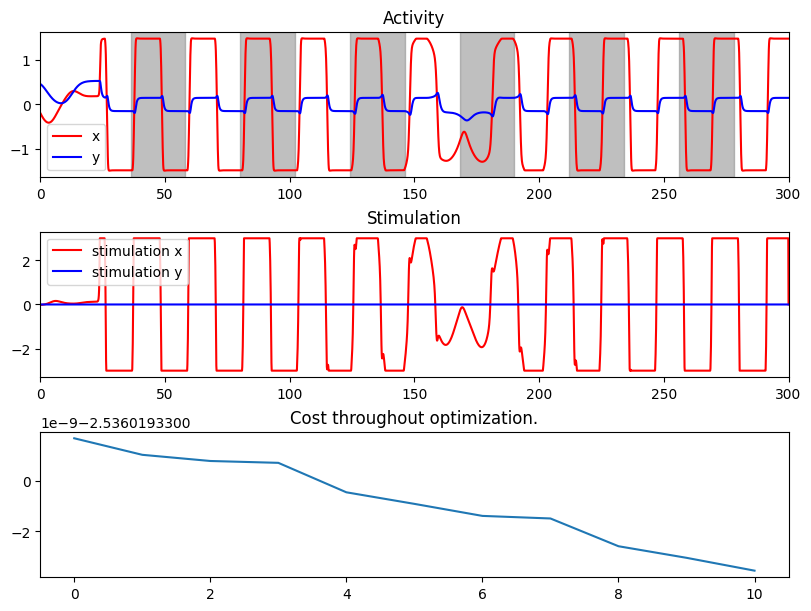

Optimal control with target oscillation period
L2 cost weight =  1e-05
Compute control for a deterministic system
Cost in iteration 0: -2.639335182587458
Final cost : -2.639335208850087
[12.5, 22.1, 22.1, 22.0, 22.1, 22.1, 21.0, 12.100000000000001, 22.1, 22.1, 22.1, 22.0]


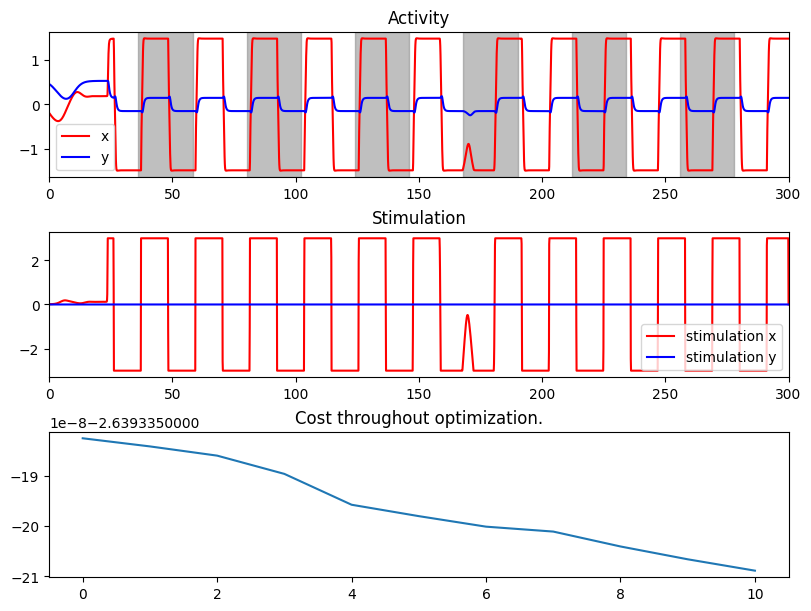

--------------------------------
PHASE COST
--------------------------------
AUTO CORRELATION COST


In [60]:
it = 10
pr = np.arange(0,1001,100)
proms = [0.02, 0.05, 0.1, 0.3]

maxstr = 3.

for pind in range(len(comp_points)):
    p = comp_points[pind]
    print("--------------------------------")
    print("--------------------------------")
    print("--------------------------------")
    print("POINT : ", p)
    print("Target period = ", target_period)

    if pind not in [2,3]:
        continue

    initinp = getinit(zero_control.shape)

    model.params.x_ou_mean = p[0]
    model.params.y_ou_mean = p[1]

    model.params["x_ext"] = zero_input
    model.params["y_ext"] = zero_input
    model.run()
    
    model.params.xs_init = np.array([[ model.x[0,-1] ]])
    model.params.ys_init = np.array([[ model.y[0,-1] ]])

    print("--------------------------------")
    print("FOURIER COST")

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        #break

        model_controlled = oc_hopf.OcHopf(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if type(results["controls"][pind][iw]) != type(None):
            model_controlled.control = results["controls"][pind][iw]
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["periods"][pind][iw] = getperiods(model_controlled.get_xs()[0,0,int0:], proms[iw])
        results["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control, cost_array=model_controlled.cost_history)

    print("--------------------------------")
    print("PHASE COST")

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        break

        model_controlled = oc_hopf.OcHopf(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_phase"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if False and type(results["controls"][pind+3][iw]) != type(None):
            model_controlled.control = results["controls"][pind+3][iw]
            model_controlled.update_input()
        else:
            model_controlled.control = initinp
            model_controlled.update_input()
        
        model_controlled.optimize(it)
        results["periods"][pind+3][iw] = getperiods(model_controlled.get_xs()[0,0,int0:], proms[iw])
        results["controls"][pind+3][iw] = model_controlled.control.copy()

        plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control, cost_array=model_controlled.cost_history)


    print("--------------------------------")
    print("AUTO CORRELATION COST")

    for iw in range(len(w2_array)):
        w2 = w2_array[iw]

        break

        model_controlled = oc_hopf.OcHopf(model, target_period, print_array=pr, cost_interval=(int0,None), control_matrix = controlmat, )
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_ac"] = 1.
        model_controlled.weights["w_2"] = w2
        print("L2 cost weight = ", w2)

        if False and type(results["controls"][pind+6][iw]) != type(None):
            model_controlled.control = results["controls"][pind+6][iw]
            model_controlled.update_input()
        else:
            model_controlled.control = initinp
            model_controlled.update_input()
        
        model_controlled.optimize(it)
        results["periods"][pind+6][iw] = getperiods(model_controlled.get_xs()[0,0,int0:], proms[iw])
        results["controls"][pind+6][iw] = model_controlled.control.copy()

        plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), target_period, model_controlled.control, cost_array=model_controlled.cost_history)

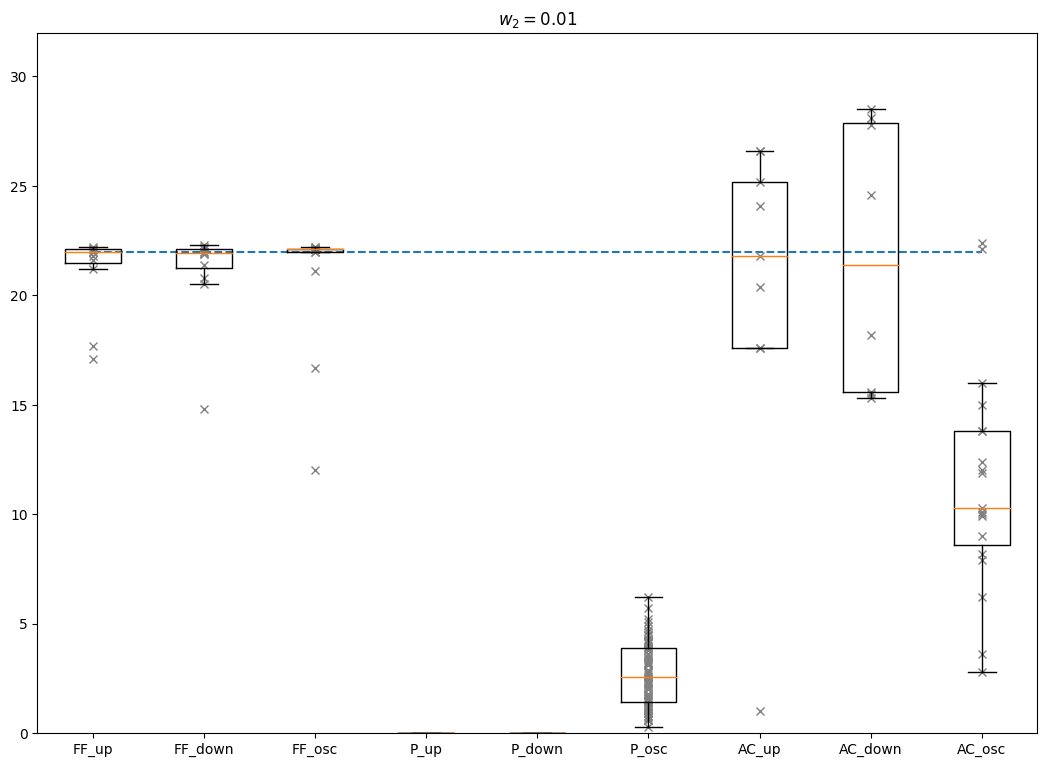

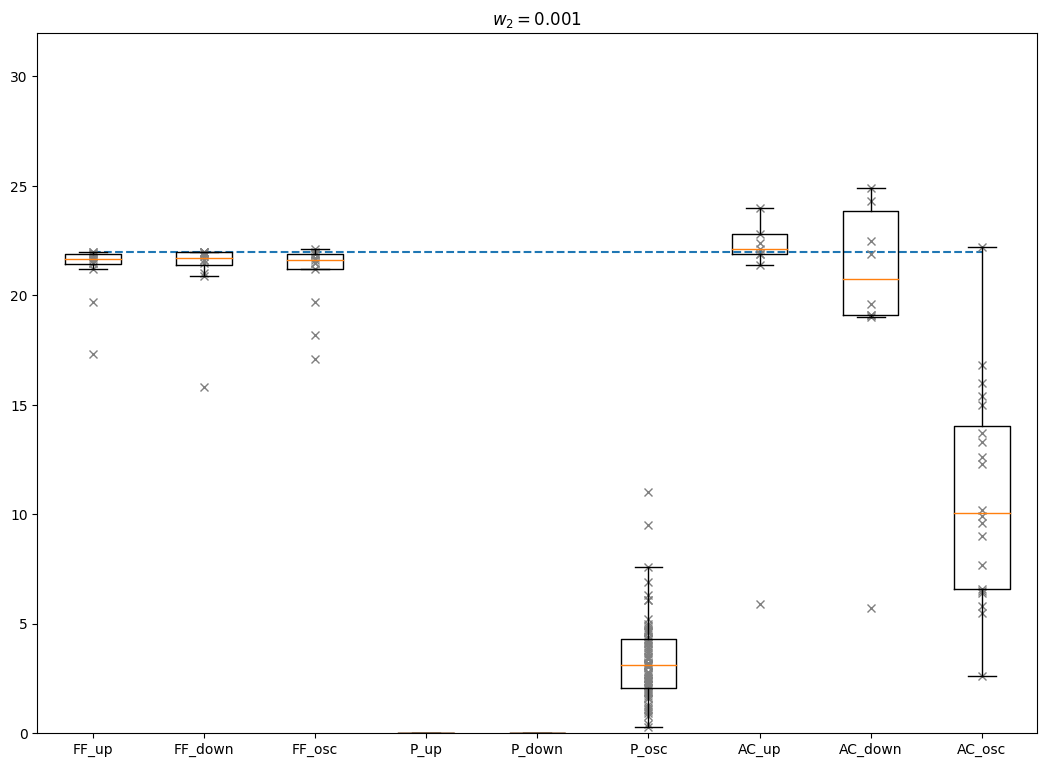

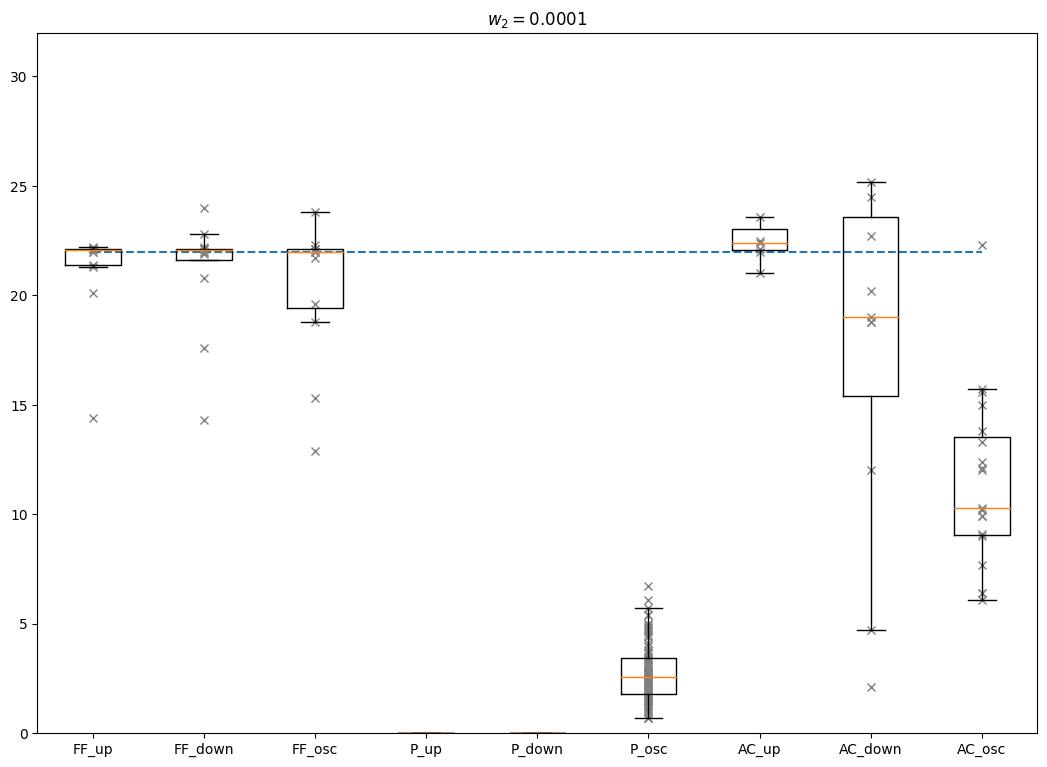

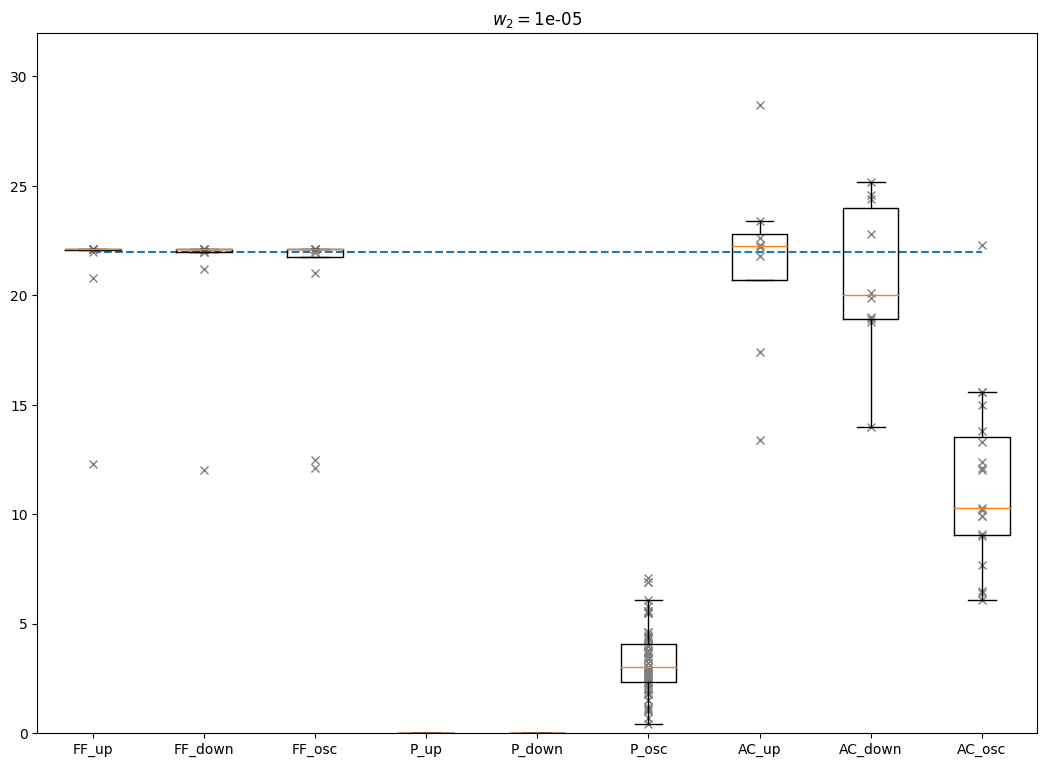

In [61]:
for iw in range(len(w2_array)):
    ydata = []
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])

    for i in range(9):
        if len(results["periods"][i][iw]) != 0:
            ydata.append(results["periods"][i][iw])
            for dpoint in results["periods"][i][iw]:
                ax.plot(i+1, dpoint, marker="x", color="grey")
        else:
            ydata.append([0])
            
    ax.boxplot(ydata, showfliers=False)
    ax.plot()
    ax.hlines(target_period, 1., 9., linestyle="--")
    ax.set_xticklabels(results["task"])
    ax.set_ylim(0., target_period+10)
    ax.set_title(r"$w_2 = $" + "{}".format(w2_array[iw]))
    plt.show()
    fig.savefig("hopf_" + str(iw) + ".png", bbox_inches='tight')

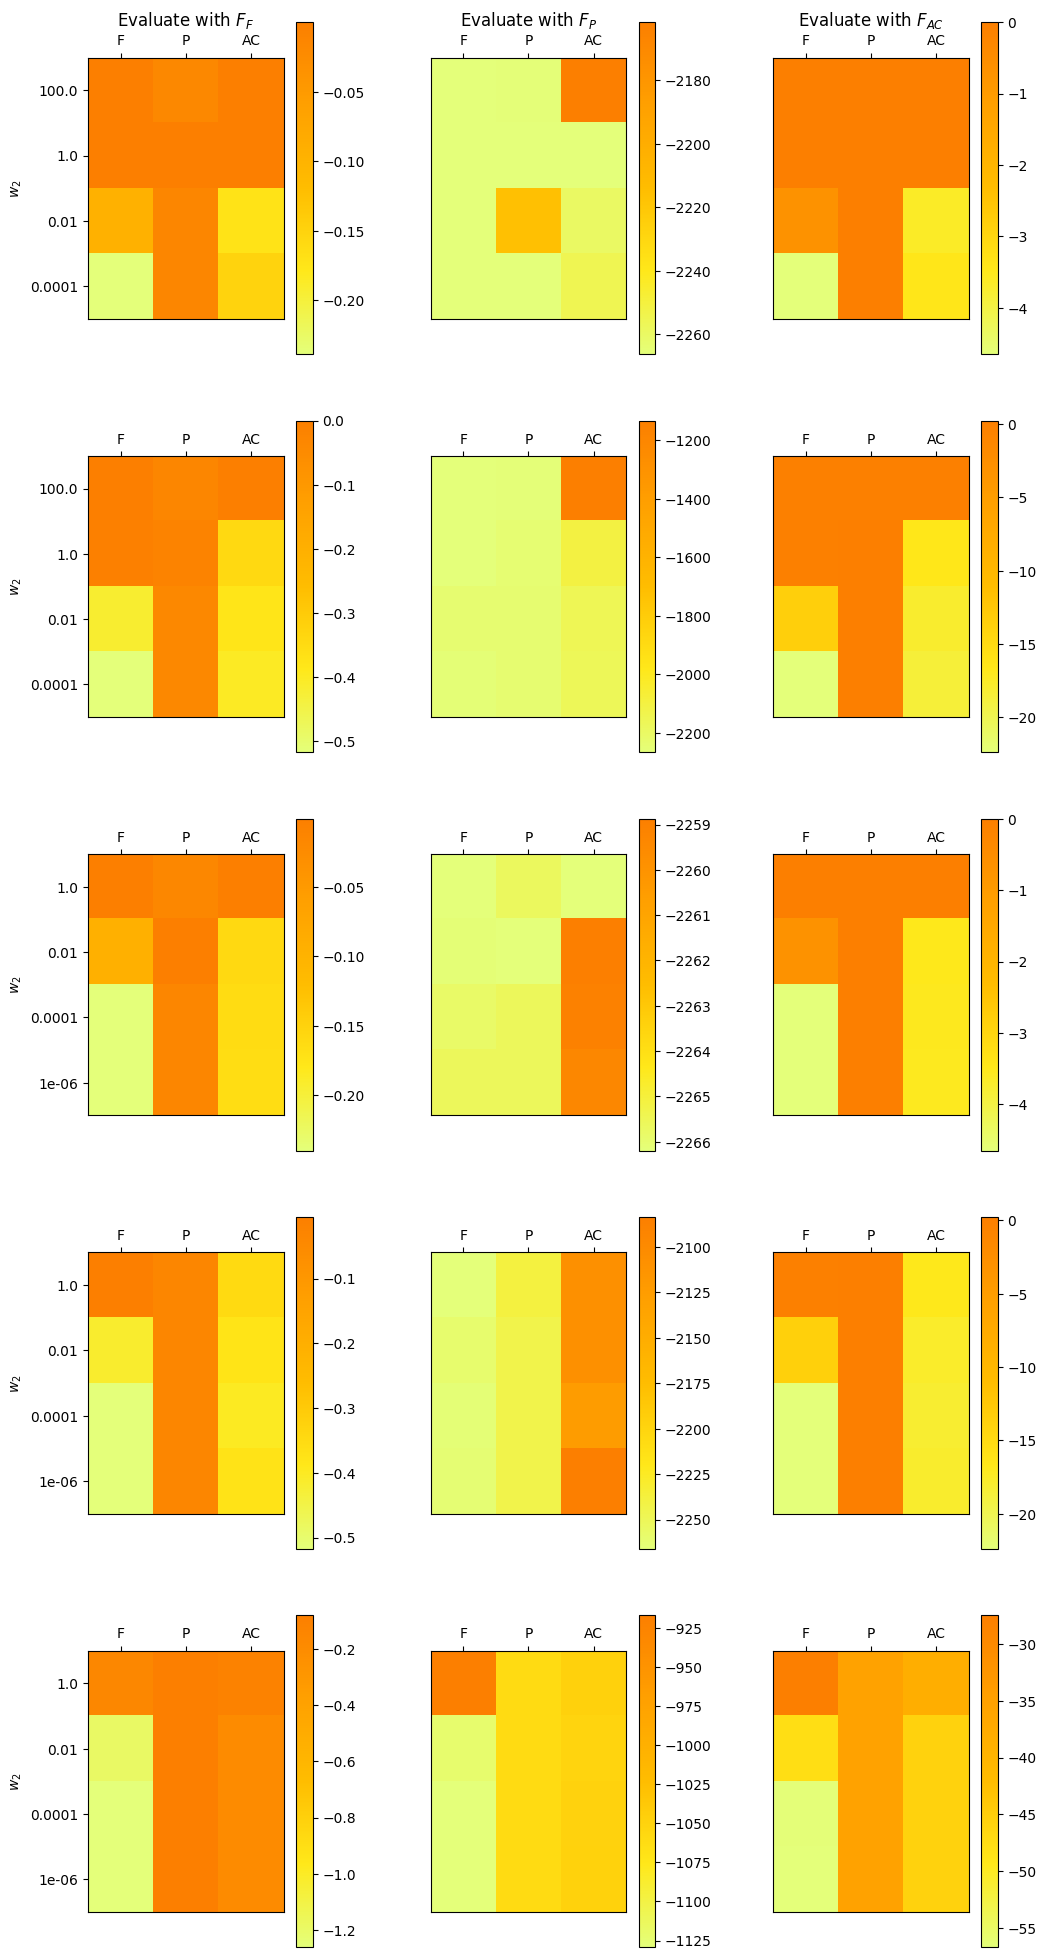

In [43]:
eval_cost = [r"Evaluate with $F_F$", r"Evaluate with $F_P$", r"Evaluate with $F_{AC}$"]
comp_cost = ["F", "P", "AC"]

fig, ax = plt.subplots(len(comp_points),len(eval_cost), figsize=(12,5*len(comp_points)))
plt.subplots_adjust( wspace=0.4, hspace=0.2)

for ip in range(len(comp_points)):
    eval = []
    eval.append(np.vstack([results["cost_f"][ip,0,:], results["cost_f"][ip,1,:], results["cost_f"][ip,2,:]]))
    eval.append(np.vstack([results["cost_p"][ip,0,:], results["cost_p"][ip,1,:], results["cost_p"][ip,2,:]]))
    eval.append(np.vstack([results["cost_ac"][ip,0,:], results["cost_ac"][ip,1,:], results["cost_ac"][ip,2,:]]))

    weights_str = []
    for w in results["w2"][ip]:
        weights_str.append(str(w))

    for ie in range(len(eval)):
        e = eval[ie]
        im = ax[ip,ie].imshow( e.T, cmap='Wistia')

        ccbar = ax[ip,ie].figure.colorbar(im, ax=ax[ip,ie])

        ax[ip,ie].set_xticks(np.arange(len(comp_cost)))
        ax[ip,ie].set_xticklabels(comp_cost)
        ax[ip,ie].xaxis.tick_top()        
        ax[ip,ie].set_yticks([])

        if ip == 0:
            ax[ip,ie].set_title(eval_cost[ie])

    ax[ip,0].set_yticks(np.arange(len(weights_str)))
    ax[ip,0].set_yticklabels(weights_str)
    ax[ip,0].set_ylabel(r"$w_2$")

plt.show()